# 299: Exampville Simulated Data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import larch
from more_itertools import pairwise

larch.__version__

'5.3.5'

Welcome to Exampville, the best simulated town in this here part of the internet!

Exampville is provided with Larch, and uses the
kind of data that a transportation planner might have available when building
a travel model.  However, this data is entirely fictional.

This page walks through the creation of this synthetic data.

In [2]:
seed=0
np.random.seed(seed)

In [3]:
import larch.exampville

## Travel Analysis Zones

We start with a shape file delineating some travel analysis zones. 
(Five bonus points if you can identify the real American city 
from which these tract shapes were derived.)

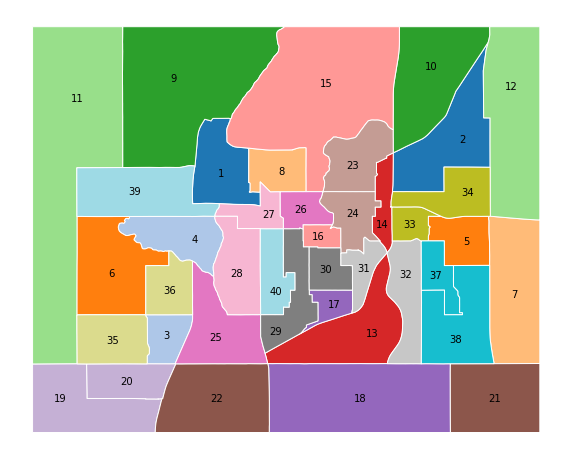

In [4]:
taz_shape = gpd.read_file("zip://"+larch.exampville.files.shapefile)
ax = taz_shape.plot(edgecolor='w', figsize=(10,10), cmap='tab20')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Put Zone labels in the meatiest part of the zone shape...
for idx, row in taz_shape.iterrows():
    shrink = row['geometry']
    while True:
        try: 
            shrink1 = shrink.buffer(-5)
            if shrink1.area <= 0:
                break
            else:
                shrink = shrink1
        except:
            break
    ax.annotate(
        s=row['TAZ'], 
        xy=tuple(shrink.representative_point().coords)[0], 
        horizontalalignment='center',
        verticalalignment='center',
    )

In [5]:
higher_income_tazs = [2,33,34,5]
lower_income_tazs = [40,29,30,17,16]

In [6]:
nZones = len(taz_shape)

In [7]:
zones_cbd = [36]
zones_urb = [4,28,25,3,35,6]

## Households

In [8]:
n_hh = 5000

In [9]:
### Group 1: In-town density
n_hh_1 = 3500

mean = [650, 400, 11, 0.35, 0.52]
i_y = 80
i_x = 100
v_y = -22
v_x = 10
s_x = 10
s_y = -22
s_v = 0.21
s_i = 0.1
cov = [
    [44000, 25000, i_x,  v_x,  s_x], 
    [25000, 44000, i_y,  v_y,  s_y], 
    [  i_x,   i_y, 1.0,  0.4,  s_i],
    [  v_x,   v_y, 0.4, 0.35,  s_v],
    [  s_x,   s_y, s_i,  s_v, 0.35],
] 

x, y, income, veh, hhsz = np.random.multivariate_normal(mean, cov, n_hh_1).T



# Assemble into a DataFrame
hh_locations = pd.DataFrame.from_dict({
    'X':np.round(x,2),
    'Y':np.round(y,2),
    'INCOME':np.exp(income).astype(int),
    'N_VEHICLES':np.exp(veh).astype(int),
    'HHSIZE':np.exp(hhsz).astype(int)+1,
})

# Convert to a GeoDataFrame
hh_locations = gpd.GeoDataFrame(
    hh_locations, 
    geometry=gpd.points_from_xy(hh_locations.X, hh_locations.Y),
    crs={},
)

# Attach HOMETAZ, and drop points outside the region.
hh_locations = gpd.sjoin(hh_locations, taz_shape[['TAZ','geometry']], how='inner', op='within')

In [10]:
hh_locations.HHSIZE.statistics(discrete=True)

┣               n: 3169
┣         minimum: 1
┣         maximum: 11
┣          median: 2.0
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 2.4534553486904387
┣           stdev: 1.262786875252692
┣           zeros: 0
┣       positives: 3169
┣       negatives: 0
┣ nonzero_minimum: 1
┣ nonzero_maximum: 11
┣    nonzero_mean: 2.4534553486904387
┣   nonzero_stdev: 1.262786875252692

In [11]:

pd.pivot_table(
    hh_locations,
    index='HHSIZE', 
    columns='N_VEHICLES',
    aggfunc={'X':'size'},
).fillna(0).astype(int)

X                                  
N_VEHICLES   0    1    2   3   4   5  6  7  9  15
HHSIZE                                           
1           363  220   29   2   0   0  0  0  0  0
2           402  712  202  45  10   3  0  0  0  0
3            75  330  164  60  23  10  4  1  0  0
4            15  123   99  42  28   9  3  1  0  0
5             1   37   29  25   8   1  5  1  1  0
6             0    7   18  12   7   3  0  0  0  0
7             2    5    3   5   0   1  0  1  0  0
8             0    2    2   2   1   1  1  0  0  1
9             0    0    4   2   2   1  1  0  0  0
10            0    0    1   0   0   0  0  0  0  0
11            0    0    0   0   0   1  0  0  0  0

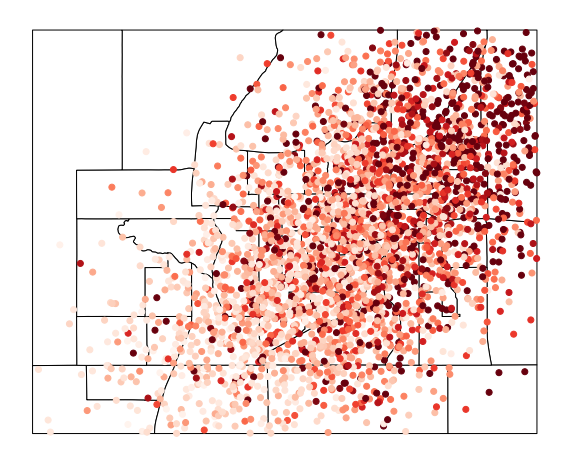

In [12]:
ax = taz_shape.plot(edgecolor='k', figsize=(10,10), color='w')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
hh_locations.plot(ax=ax, column='INCOME', alpha=1, cmap='Reds', vmax=150000);

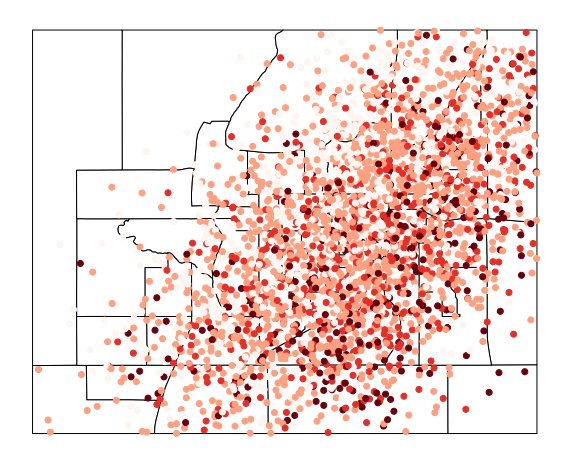

In [13]:
ax = taz_shape.plot(edgecolor='k', figsize=(10,10), color='w')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
hh_locations.plot(ax=ax, column='N_VEHICLES', alpha=1, cmap='Reds', vmax=3);

In [14]:
hh_locations.INCOME.statistics()

┣               n: 3169
┣         minimum: 1159
┣         maximum: 1495622
┣          median: 58545.0
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 94789.0766803408
┣           stdev: 118463.08967258588
┣           zeros: 0
┣       positives: 3169
┣       negatives: 0
┣ nonzero_minimum: 1159
┣ nonzero_maximum: 1495622
┣    nonzero_mean: 94789.0766803408
┣   nonzero_stdev: 118463.08967258588

In [15]:
hh_locations.head()

,X,Y,INCOME,N_VEHICLES,HHSIZE,geometry,index_right,TAZ
0,361.35,33.34,6026,1,4,POINT (361.350 33.340),21,22
112,272.08,30.77,30538,0,1,POINT (272.080 30.770),21,22
156,424.18,72.55,24131,1,1,POINT (424.180 72.550),21,22
160,464.48,61.30,34838,1,2,POINT (464.480 61.300),21,22
186,328.95,129.36,29337,0,1,POINT (328.950 129.360),21,22


In [16]:
#### Group 2: Regional base population

n_hh_2 = n_hh - len(hh_locations) # Enough to get back to the desired total

mean = [650, 400, 20000, 0.45, 0.52]
i_y = 0
i_x = 0
v_y = 0
v_x = 0
s_x = 0
s_y = 0
v_i = 846
s_v = 0.28
s_i = 600
cov = [
    [44000,     0,    i_x,  v_x,  s_x], 
    [    0, 44000,    i_y,  v_y,  s_y], 
    [  i_x,   i_y,9000000,  v_i,  s_i],
    [  v_x,   v_y,    v_i, 0.25,  s_v],
    [  s_x,   s_y,    s_i,  s_v, 0.35],
] 

In [17]:
x2, y2, i2, v2, s2 = np.random.multivariate_normal(mean, cov, n_hh_2).T


x2 = np.random.random(n_hh_2)*1000
y2 = np.random.random(n_hh_2)*800
# i2 = np.exp(np.random.random(n_hh_2)*3+8).astype(int)
# v2 = np.exp(np.random.random(n_hh_2)*1.3)
# s2 = v2 + np.exp(np.random.random(n_hh_2)*0.3)

# Assemble into a DataFrame
hh_locations2 = pd.DataFrame.from_dict({
    'X':np.round(x2,2),
    'Y':np.round(y2,2),
    'INCOME':(i2),
    'N_VEHICLES':np.exp(v2).astype(int),
    'HHSIZE':np.exp(s2).astype(int)+1,
})

# Convert to a GeoDataFrame
hh_locations2 = gpd.GeoDataFrame(
    hh_locations2, 
    geometry=gpd.points_from_xy(hh_locations2.X, hh_locations2.Y),
    crs={},
)

# Attach HOMETAZ
hh_locations2 = gpd.sjoin(hh_locations2, taz_shape[['TAZ','geometry']], how='inner', op='within')

In [18]:
hh_locations2.head()

,X,Y,INCOME,N_VEHICLES,HHSIZE,geometry,index_right,TAZ
0,266.54,78.10,21851.702304,1,2,POINT (266.540 78.100),21,22
10,284.48,123.81,22175.696585,1,2,POINT (284.480 123.810),21,22
19,329.07,93.00,23665.459873,4,6,POINT (329.070 93.000),21,22
26,350.79,133.95,20651.496338,1,3,POINT (350.790 133.950),21,22
41,392.46,100.41,15006.766402,1,2,POINT (392.460 100.410),21,22


In [19]:
hh_locations2.INCOME.statistics()

┣               n: 1831
┣         minimum: 9091.694830180175
┣         maximum: 30655.565862265605
┣          median: 20061.641663502065
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 20051.44933225138
┣           stdev: 2994.003712899102
┣           zeros: 0
┣       positives: 1831
┣       negatives: 0
┣ nonzero_minimum: 9091.694830180175
┣ nonzero_maximum: 30655.565862265605
┣    nonzero_mean: 20051.44933225138
┣   nonzero_stdev: 2994.003712899102

In [20]:
hh_locations2.N_VEHICLES.statistics(discrete=True)

┣               n: 1831
┣         minimum: 0
┣         maximum: 11
┣          median: 1.0
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 1.2790824685963955
┣           stdev: 1.0267819582622217
┣           zeros: 327
┣       positives: 1504
┣       negatives: 0
┣ nonzero_minimum: 1
┣ nonzero_maximum: 11
┣    nonzero_mean: 1.5571808510638299
┣   nonzero_stdev: 0.9222004958396711

In [21]:
hh_locations2.corr()

,X,Y,INCOME,N_VEHICLES,HHSIZE,index_right,TAZ
X,1.000000,-0.018466,-0.012184,-0.000933,0.023437,0.042336,0.042336
Y,-0.018466,1.000000,-0.000632,0.006702,0.010311,-0.335959,-0.335959
INCOME,-0.012184,-0.000632,1.000000,0.505674,0.296677,-0.006175,-0.006175
N_VEHICLES,-0.000933,0.006702,0.505674,1.000000,0.889067,0.000554,0.000554
HHSIZE,0.023437,0.010311,0.296677,0.889067,1.000000,-0.003713,-0.003713
index_right,0.042336,-0.335959,-0.006175,0.000554,-0.003713,1.000000,1.000000
TAZ,0.042336,-0.335959,-0.006175,0.000554,-0.003713,1.000000,1.000000


In [22]:
#### Merge Groups

HH = pd.concat([hh_locations, hh_locations2], sort=False)

# Clean up
HH = HH.reset_index(drop=True)
HH.rename({'TAZ':'HOMETAZ'}, axis=1, inplace=True)
HH.drop('index_right', axis=1, inplace=True)

# Add HH size and ID
# HH['HHSIZE'] = (np.floor(
#     np.random.binomial(5, 0.3, [n_hh, ]) 
#     + 1 
#     + np.random.random([n_hh, ])
# )).astype(int)

#np.floor(np.random.exponential(0.8, [n_hh, ]) + 1 + np.random.random([n_hh, ])).astype(int)
HH['HHID'] = HH.index + 50000

In [23]:
HH.head()

,X,Y,INCOME,N_VEHICLES,HHSIZE,geometry,HOMETAZ,HHID
0,361.35,33.34,6026.0,1,4,POINT (361.350 33.340),22,50000
1,272.08,30.77,30538.0,0,1,POINT (272.080 30.770),22,50001
2,424.18,72.55,24131.0,1,1,POINT (424.180 72.550),22,50002
3,464.48,61.30,34838.0,1,2,POINT (464.480 61.300),22,50003
4,328.95,129.36,29337.0,0,1,POINT (328.950 129.360),22,50004


In [24]:
# HH.index = HH['HHID']
HH['HHSIZE'].statistics(discrete=True)

┣               n: 5000
┣         minimum: 1
┣         maximum: 22
┣          median: 2.0
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 2.4698
┣           stdev: 1.314034991923731
┣           zeros: 0
┣       positives: 5000
┣       negatives: 0
┣ nonzero_minimum: 1
┣ nonzero_maximum: 22
┣    nonzero_mean: 2.4698
┣   nonzero_stdev: 1.314034991923731

In [25]:
HH['INCOME'].statistics()

┣               n: 5000
┣         minimum: 1159.0
┣         maximum: 1495622.0
┣          median: 27261.06802456764
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 67420.15754547046
┣           stdev: 100966.07139915966
┣           zeros: 0
┣       positives: 5000
┣       negatives: 0
┣ nonzero_minimum: 1159.0
┣ nonzero_maximum: 1495622.0
┣    nonzero_mean: 67420.15754547046
┣   nonzero_stdev: 100966.07139915966

In [26]:
HH.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   X           5000 non-null   float64 
 1   Y           5000 non-null   float64 
 2   INCOME      5000 non-null   float64 
 3   N_VEHICLES  5000 non-null   int64   
 4   HHSIZE      5000 non-null   int64   
 5   geometry    5000 non-null   geometry
 6   HOMETAZ     5000 non-null   int64   
 7   HHID        5000 non-null   int64   
dtypes: float64(3), geometry(1), int64(4)
memory usage: 312.6 KB


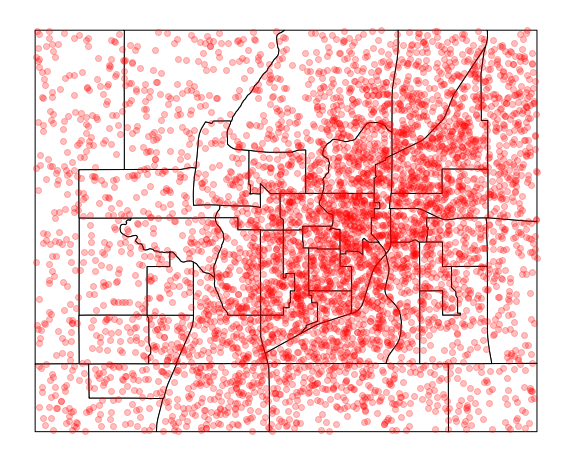

In [27]:
ax = taz_shape.plot(edgecolor='k', figsize=(10,10), color='w')
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
HH.plot(ax=ax, color='red', alpha=0.25);

## People

In [28]:

HHsize = HH['HHSIZE']
n_PER = np.sum(HHsize)

PER = {}
PERidx = PER['idx'] = np.arange(n_PER, dtype=np.int64)
PERid = PER['PERSONID'] = np.asarray([60000 + i for i in PER['idx']])
PERhhid = PER['HHID'] = np.zeros(n_PER, dtype=np.int64)
PERhhidx = PER['HHIDX'] = np.zeros(n_PER, dtype=np.int64)
PERage = PER['AGE'] = np.zeros(n_PER, dtype=np.int64)
n2 = 0
for n1 in range(n_hh):
    PER['HHID'][n2:(n2 + HHsize[n1])] = HH['HHID'][n1]
    PER['HHIDX'][n2:(n2 + HHsize[n1])] = HH.index[n1]
    
    PER['AGE'][n2] = int(np.random.random() * 67 + 18)
    if HHsize[n1]>1:
        nphh = HHsize[n1]-1
        PER['AGE'][n2+1:n2+1+nphh] = (np.random.random(nphh) * 80 + 5).astype(np.int64)
    n2 += HHsize[n1]
    
    
    
PERworks = PER['WORKS'] = ((np.random.random(n_PER) > 0.15) & (PERage > 16) & (PERage < 70)).astype(np.int64)

PER = pd.DataFrame.from_dict(PER)
PER.drop('idx', axis=1, inplace=True)


In [29]:
PER['AGE'].statistics()

┣               n: 12349
┣         minimum: 5
┣         maximum: 84
┣          median: 48.0
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 47.22916835371285
┣           stdev: 21.846714300032925
┣           zeros: 0
┣       positives: 12349
┣       negatives: 0
┣ nonzero_minimum: 5
┣ nonzero_maximum: 84
┣    nonzero_mean: 47.22916835371285
┣   nonzero_stdev: 21.846714300032925

In [30]:
HH.head()

,X,Y,INCOME,N_VEHICLES,HHSIZE,geometry,HOMETAZ,HHID
0,361.35,33.34,6026.0,1,4,POINT (361.350 33.340),22,50000
1,272.08,30.77,30538.0,0,1,POINT (272.080 30.770),22,50001
2,424.18,72.55,24131.0,1,1,POINT (424.180 72.550),22,50002
3,464.48,61.30,34838.0,1,2,POINT (464.480 61.300),22,50003
4,328.95,129.36,29337.0,0,1,POINT (328.950 129.360),22,50004


In [31]:
n_veh = HH[['N_VEHICLES', 'INCOME']]
n_veh.index = HH.HHID
PER = pd.merge(PER, n_veh, left_on='HHID', right_index=True)

In [32]:
vcounts = PER.N_VEHICLES.value_counts().sort_index()
vcounts

0     1855
1     5374
2     2965
3     1199
4      528
5      239
6      120
7       19
9       20
11      22
15       8
Name: N_VEHICLES, dtype: int64

In [33]:
PER.N_VEHICLES.statistics(discrete=True)

┣               n: 12349
┣         minimum: 0
┣         maximum: 15
┣          median: 1.0
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 1.587415985100008
┣           stdev: 1.3546955271124952
┣           zeros: 1855
┣       positives: 10494
┣       negatives: 0
┣ nonzero_minimum: 1
┣ nonzero_maximum: 15
┣    nonzero_mean: 1.8680198208500096
┣   nonzero_stdev: 1.2788395049811396

In [34]:
PERnworktours = np.zeros_like(PERage)
PERnothertours = np.zeros_like(PERage)
i = 0
for nv,nt in vcounts.items():
    if nv==0:
        work_rates, other_rates = [0.25, 0.70, 0.04, 0.01], [0.74, 0.2, 0.05, 0.01]
    elif nv==1:
        work_rates, other_rates = [0.13, 0.74, 0.09, 0.04], [0.2, 0.5, 0.2, 0.1]
    elif nv==2:
        work_rates, other_rates = [0.10, 0.70, 0.17, 0.03], [0.1, 0.5, 0.3, 0.1]
    elif nv==3:
        work_rates, other_rates = [0.07, 0.61, 0.26, 0.06], [0.1, 0.4, 0.3, 0.2]
    else:
        work_rates, other_rates = [0.05, 0.53, 0.33, 0.09], [0.1, 0.3, 0.4, 0.2]
    
    work_rates = np.array(work_rates)
    other_rates = np.array(other_rates)
    
    for income_under, income_over in pairwise([np.inf, 150_000, 120_000, 90_000, 60_000, 30_000, -np.inf]):
        PERv = (PER.N_VEHICLES == nv) & (PER.INCOME>=income_over) & (PER.INCOME<income_under)
        if income_over == 150_000:
            work_rates_ = work_rates + np.array([-0.04, -0.10, 0.10, 0.04])
            other_rates_ = other_rates + np.array([-0.07, -0.13, 0.13, 0.07])
        elif income_over == 120_000:
            work_rates_ = work_rates + np.array([-0.03, -0.08, 0.08, 0.03])
            other_rates_ = other_rates + np.array([-0.05, -0.1, 0.13, 0.02])
        elif income_over == 90_000:
            work_rates_ = work_rates + np.array([-0.02, -0.06, 0.07, 0.01])
            other_rates_ = other_rates + np.array([-0.03, -0.07, 0.08, 0.02])
        elif income_over == 60_000:
            work_rates_ = work_rates + np.array([-0.01, -0.04, 0.05, 0.0])
            other_rates_ = other_rates + np.array([-0.02, -0.03, 0.04, 0.01])
        elif income_over == 30_000:
            work_rates_ = work_rates 
            other_rates_ = other_rates 
        else:
            work_rates_ = work_rates + np.array([0.1, 0.05, -0.05, -0.1])
            other_rates_ = other_rates + np.array([0.2, 0.05, -0.05, -0.2])
        j = sum(PERv)    
        
        work_rates_[work_rates_<0.0001] = 0.0001
        work_rates_ /= work_rates_.sum()

        other_rates_[other_rates_<0.0001] = 0.0001
        other_rates_ /= other_rates_.sum()

        PERnworktours[PERv] = np.random.choice([0, 1, 2, 3], size=[j, ], replace=True, p=work_rates_).astype(np.int64) * PER['WORKS'][PERv]
        PERnothertours[PERv] = np.random.choice([0, 1, 2, 3], size=[j, ], replace=True, p=other_rates_).astype(np.int64)

    

In [35]:
for income_under, income_over in pairwise([np.inf, 150_000, 120_000, 90_000, 60_000, 0]):
    print(income_under, income_over)

inf 150000
150000 120000
120000 90000
90000 60000
60000 0


In [36]:
## Add counts of tours

# PER['N_WORK_TOURS'] = PERnworktours = np.random.choice([0, 1, 2, 3], size=[n_PER, ], replace=True, p=[0.1, 0.8, 0.07, 0.03]).astype(
#     np.int64) * PER['WORKS']
# PER['N_OTHER_TOURS'] = PERnothertours = np.random.choice([0, 1, 2, 3], size=[n_PER, ], replace=True, p=[0.2, 0.5, 0.2, 0.1]).astype(np.int64)

PER['N_WORK_TOURS'] = PERnworktours
PER['N_OTHER_TOURS'] = PERnothertours
PER['N_TOURS'] = PERntours = PERnworktours + PERnothertours

In [37]:
PER.INCOME.statistics()

┣               n: 12349
┣         minimum: 1159.0
┣         maximum: 1495622.0
┣          median: 28757.0
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 72014.08492626138
┣           stdev: 109763.15833460975
┣           zeros: 0
┣       positives: 12349
┣       negatives: 0
┣ nonzero_minimum: 1159.0
┣ nonzero_maximum: 1495622.0
┣    nonzero_mean: 72014.08492626138
┣   nonzero_stdev: 109763.15833460975

In [38]:
# PER.sort_index(inplace=True)

In [39]:
PER.head()

,PERSONID,HHID,HHIDX,AGE,WORKS,N_VEHICLES,INCOME,N_WORK_TOURS,N_OTHER_TOURS,N_TOURS
0,60000,50000,0,33,1,1,6026.0,1,0,1
1,60001,50000,0,27,1,1,6026.0,1,1,2
2,60002,50000,0,31,1,1,6026.0,1,1,2
3,60003,50000,0,81,0,1,6026.0,0,2,2
4,60004,50001,1,39,1,0,30538.0,1,0,1


## Employment

In [40]:
total_employment = PER['WORKS'].sum()
total_employment

7394

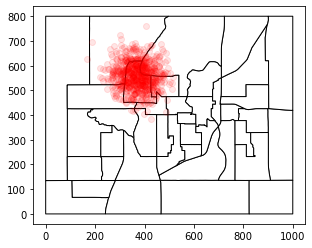

In [41]:
#### Group 1 Retail Locus

n_retail_jobs_1 = int(total_employment * 0.1)

mean = [370, 560,]
cov = [
    [3000, 0], 
    [0, 3000], 
] 
x, y = np.random.multivariate_normal(mean, cov, n_retail_jobs_1).T
retail_locations_1 = pd.DataFrame.from_dict({
    'X':x,
    'Y':y,
})

retail_locations_1 = gpd.GeoDataFrame(
    retail_locations_1, 
    geometry=gpd.points_from_xy(retail_locations_1.X, retail_locations_1.Y),
    crs={},
)
retail_locations_1 = gpd.sjoin(retail_locations_1, taz_shape[['TAZ','geometry']], how='inner', op='within')

ax =taz_shape.plot(edgecolor='k', color='w')
retail_locations_1.plot(ax=ax, color='red', alpha=0.1);

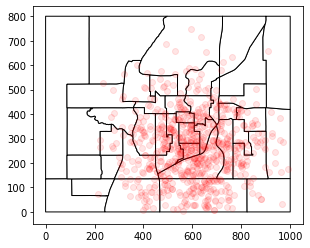

In [42]:
#### Group 2 Retail Background

n_retail_jobs_2 = int(total_employment * 0.1)

mean = [600, 250,]
cov = [
    [22000, 0], 
    [0, 22000], 
] 
x, y = np.random.multivariate_normal(mean, cov, n_retail_jobs_2).T
retail_locations_2 = pd.DataFrame.from_dict({
    'X':x,
    'Y':y,
})

retail_locations_2 = gpd.GeoDataFrame(
    retail_locations_2, 
    geometry=gpd.points_from_xy(retail_locations_2.X, retail_locations_2.Y),
    crs={},
)
retail_locations_2 = gpd.sjoin(retail_locations_2, taz_shape[['TAZ','geometry']], how='inner', op='within')

ax =taz_shape.plot(edgecolor='k', color='w')
retail_locations_2.plot(ax=ax, color='red', alpha=0.1)

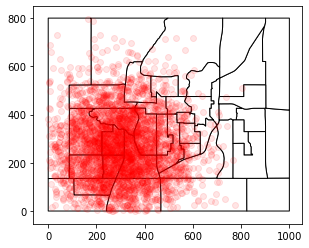

In [43]:
#### Group 3 Downtown Locus

n_other_jobs_1 = int(total_employment * 0.5)

mean = [300, 250,]
cov = [
    [22000, 0], 
    [0, 22000], 
] 
x, y = np.random.multivariate_normal(mean, cov, n_other_jobs_1).T
other_locations_1 = pd.DataFrame.from_dict({
    'X':x,
    'Y':y,
})

other_locations_1 = gpd.GeoDataFrame(
    other_locations_1, 
    geometry=gpd.points_from_xy(other_locations_1.X, other_locations_1.Y),
    crs={},
)
other_locations_1 = gpd.sjoin(other_locations_1, taz_shape[['TAZ','geometry']], how='inner', op='within')

ax =taz_shape.plot(edgecolor='k', color='w')
other_locations_1.plot(ax=ax, color='red', alpha=0.1)

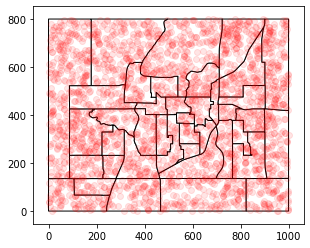

In [44]:
#### Group 4 Background

n_other_jobs_2 = total_employment - len(other_locations_1) - len(retail_locations_2) - len(retail_locations_1)

x2 = np.random.random(n_other_jobs_2)*1000
y2 = np.random.random(n_other_jobs_2)*800
other_locations_2 = pd.DataFrame.from_dict({
    'X':x2,
    'Y':y2,
})
other_locations_2 = gpd.GeoDataFrame(
    other_locations_2, 
    geometry=gpd.points_from_xy(other_locations_2.X, other_locations_2.Y),
    crs={},
)

other_locations_2 = gpd.sjoin(other_locations_2, taz_shape[['TAZ','geometry']], how='inner', op='within')

ax =taz_shape.plot(edgecolor='k', color='w')
other_locations_2.plot(ax=ax, color='red', alpha=0.1);

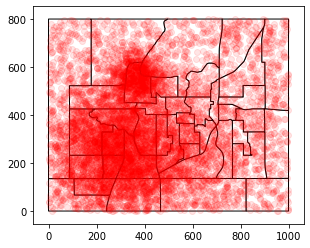

In [45]:
## Merge all employment

retail_locations_1['JOBTYPE'] = 'retail'
retail_locations_2['JOBTYPE'] = 'retail'
other_locations_1['JOBTYPE'] = 'nonretail'
other_locations_2['JOBTYPE'] = 'nonretail'


job_location = pd.concat([retail_locations_1,retail_locations_2,other_locations_1,other_locations_2])

job_location = job_location.reset_index(drop=True)
job_location['JOBTYPE'] = job_location['JOBTYPE'].astype('category')

ax =taz_shape.plot(edgecolor='k', color='w')
job_location.plot(ax=ax, color='red', alpha=0.1);

In [46]:
taz_employment = job_location.groupby(['TAZ','JOBTYPE']).size().unstack().fillna(0).astype(int)
taz_employment.rename({'retail':'RETAIL_EMP', 'nonretail':'NONRETAIL_EMP'}, axis=1, inplace=True)

In [47]:
taz_employment['TOTAL_EMP'] = taz_employment['NONRETAIL_EMP'] + taz_employment['RETAIL_EMP']

In [48]:
taz_employment.columns.name = None

In [49]:
taz_employment.head()

,NONRETAIL_EMP,RETAIL_EMP,TOTAL_EMP
TAZ,,,
1,118,340,458
2,91,0,91
3,197,2,199
4,277,8,285
5,44,13,57


In [50]:
# Save
taz_employment.to_csv(larch.exampville._files(seed).employment)

## Network Graph

In [51]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


In [52]:
highway_route = [12,2,10,23,24,26,27,39,11]
transit_line = [39,6,36,25,29,17,31,14,34]

In [53]:
speed_road = 3 # minutes per mile
speed_highway = 1 # minutes per mile
speed_train = 1.2 # minutes per mile
speed_walk = 20 # minutes per mile
speed_bike = 5 # minutes per mile

In [54]:
g = nx.DiGraph()

for index, zone in taz_shape.iterrows():   
    # get 'not disjoint' countries
    neighbors = taz_shape[~taz_shape.geometry.disjoint(zone.geometry)].TAZ.tolist()
    neighborc = taz_shape[~taz_shape.geometry.disjoint(zone.geometry)].geometry.centroid.tolist()

    # add names of neighbors as NEIGHBORS value
    for name, cent in zip(neighbors,neighborc):
        if zone.TAZ != name:
            otaz, dtaz = int(zone.TAZ), int(name)
            distance = (zone.geometry.centroid.distance(cent)) / 100
            if otaz in highway_route and dtaz in highway_route:
                cartime = distance * speed_highway
            else:
                cartime = distance * speed_road
            if otaz in [25,36,3]:
                cartime += 3 # congestion
            if dtaz in [25,36,3]:
                cartime += 5 # congestion
            if otaz in transit_line and dtaz in transit_line:
                transit_ivtt = distance * speed_train
                transit_ovtt = 999999
                transit_time = transit_ivtt
            else:
                transit_ivtt = 999999
                transit_ovtt = distance * speed_walk
                transit_time = transit_ovtt
            g.add_edge(
                otaz, dtaz, 
                distance=distance, cartime=cartime,
                transit_ovtt=transit_ovtt,
                transit_ivtt=transit_ivtt,
                transit_time=transit_time,
            )


In [55]:
taz_shape.index = taz_shape.TAZ

In [56]:
centroids = taz_shape.centroid

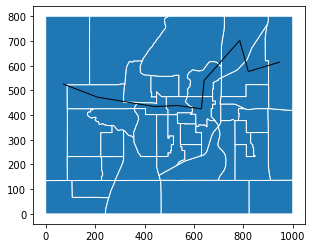

In [57]:
## Highway Map
ax = taz_shape.plot(edgecolor='w')
nx.draw_networkx_edges(    
    g, 
    pos={i:p.coords[0] for i,p in centroids.iteritems()}, 
    ax=ax,
    arrows=False,
    edgelist = list(pairwise(highway_route))
);

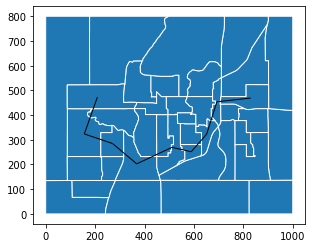

In [58]:
## Transit Map
ax = taz_shape.plot(edgecolor='w')
nx.draw_networkx_edges(    
    g, 
    pos={i:p.coords[0] for i,p in centroids.iteritems()}, 
    ax=ax,
    arrows=False,
    edgelist = list(pairwise(transit_line))
);

In [59]:
# Skim walk times

WALKDIST = np.zeros([40,40])

for otaz in range(1,41):
    shortpaths = nx.shortest_path_length(g, source=otaz, weight='distance')
    for dtaz,t in shortpaths.items():
        WALKDIST[otaz-1,dtaz-1] = t
    # Intrazonal
    WALKDIST[otaz-1,otaz-1] = np.sqrt(taz_shape.loc[otaz,'geometry'].area)/100
    
print(WALKDIST)

[[1.26008879 5.33674896 4.58318093 ... 6.18954756 1.69554975 2.37320583]
 [5.33674896 1.58559083 7.10162147 ... 3.58697088 6.58003239 4.68712856]
 [4.58318093 7.10162147 0.84878748 ... 6.03594579 3.16473549 2.58607677]
 ...
 [6.18954756 3.58697088 6.03594579 ... 1.47478351 7.36821732 4.27530036]
 [1.69554975 6.58003239 3.16473549 ... 7.36821732 1.52806696 3.1778055 ]
 [2.37320583 4.68712856 2.58607677 ... 4.27530036 3.1778055  0.93934102]]


In [60]:
# Skim car times

CARTIME = np.zeros([40,40])
CARDIST = np.zeros([40,40])

for otaz in range(1,41):
    shortpaths = nx.shortest_path(g, source=otaz, weight='cartime')
    for dtaz,pth in shortpaths.items():
        cartime, cardist = 0,0
        for i,j in pairwise(pth):
            cartime += g.edges[i,j]['cartime']
            cardist += g.edges[i,j]['distance']
        CARTIME[otaz-1,dtaz-1] = cartime
        CARDIST[otaz-1,dtaz-1] = cardist
    # Intrazonal
    intrazonal_dist = np.sqrt(taz_shape.loc[otaz,'geometry'].area)/100
    CARTIME[otaz-1,otaz-1] = intrazonal_dist * speed_road
    CARDIST[otaz-1,otaz-1] = intrazonal_dist
    if otaz in [25,36,3]:
        CARTIME[otaz-1,otaz-1] += 5 # congestion
        
print(CARTIME)

[[ 3.78026636  7.55074623 20.03817767 ... 14.84435807  5.08664924
   7.1196175 ]
 [ 7.55074623  4.75677248 21.53156082 ... 10.76091265  6.58003239
   7.46190167]
 [18.03817767 19.53156082  7.54636244 ... 26.82517266 12.95152843
  18.69703682]
 ...
 [14.84435807 10.76091265 28.82517266 ...  4.42435054 13.87364423
  12.82590109]
 [ 5.08664924  6.58003239 14.95152843 ... 13.87364423  4.58420087
   6.14890366]
 [ 7.1196175   7.46190167 20.69703682 ... 12.82590109  6.14890366
   2.81802305]]


In [61]:
## Skim Transit times 

from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

TRANSIT_IVTT = np.zeros([40,40])
TRANSIT_OVTT = np.zeros([40,40])


for otaz in range(1,41):
    shortpaths = nx.shortest_path(g, source=otaz, weight='transit_time')
    for dtaz,pth in shortpaths.items():
        ivtt, ovtt = 0,0
        for i,j in pairwise(pth):
            if g.edges[i,j]['transit_ivtt'] < 999999:
                ivtt += g.edges[i,j]['transit_ivtt']
            else:
                ovtt += g.edges[i,j]['transit_ovtt']
        if ovtt == 0:
            ovtt = np.sqrt(taz_shape.loc[otaz,'geometry'].area)/150 + np.sqrt(taz_shape.loc[dtaz,'geometry'].area)/150
        TRANSIT_IVTT[otaz-1,dtaz-1] = ivtt
        TRANSIT_OVTT[otaz-1,dtaz-1] = ovtt

In [62]:
print(TRANSIT_IVTT[:5,:5])

[[ 0.         12.16681923  3.34322095  0.         12.16681923]
 [12.16681923  0.          7.28835487  8.82359828  0.        ]
 [ 3.34322095  7.28835487  0.          0.          7.28835487]
 [ 0.          8.82359828  0.          0.          8.82359828]
 [12.16681923  0.          7.28835487  8.82359828  0.        ]]


In [63]:
print(TRANSIT_IVTT[5:10,5:10])

[[ 0.         10.27128369  4.87262088  1.89553554 10.27128369]
 [10.27128369  0.          1.65255376 12.16681923  0.        ]
 [ 4.87262088  1.65255376  0.          0.          0.        ]
 [ 1.89553554 12.16681923  0.          0.          0.        ]
 [10.27128369  0.          0.          0.          0.        ]]


In [64]:
print(TRANSIT_OVTT[:5,:5])

[[ 1.68011838 55.40770608 53.31126782 54.30474188 51.92986575]
 [55.40770608  2.1141211  42.40834339 41.86677092 39.51558199]
 [53.31126782 42.40834339  1.13171664 39.77033266 38.93050306]
 [54.30474188 41.86677092 39.77033266  1.59494151 38.38893059]
 [51.92986575 39.51558199 38.93050306 38.38893059  1.33312576]]


In [65]:
nx.shortest_path(g, source=30, weight='transit_time')[17]

[30, 17]

In [66]:
TRANSIT_OVTT[30-1,17-1]

13.623549779792938

In [67]:
print(TRANSIT_OVTT[5:10,5:10])

[[ 2.13185101 44.79634199 52.86833727 45.94660431 47.64017297]
 [44.79634199  2.23727869 96.67959495 90.7429463  92.43651496]
 [52.86833727 96.67959495  1.28229674 57.83865222 79.11952302]
 [45.94660431 90.7429463  57.83865222  3.35766701 97.40276959]
 [47.64017297 92.43651496 79.11952302 97.40276959  2.30316209]]


In [68]:
if os.path.exists(larch.exampville.files.skims):
    os.remove(larch.exampville.files.skims)

In [69]:
## Assemble Skims into an OMX File
skims_omx = larch.OMX(larch.exampville._files(seed).skims, mode='w')

In [70]:
skims_omx.add_matrix('TRANSIT_IVTT', TRANSIT_IVTT)
skims_omx.add_matrix('TRANSIT_OVTT', TRANSIT_OVTT)
skims_omx.add_matrix('TRANSIT_FARE', (TRANSIT_IVTT>0)*2.50)

skims_omx.add_matrix('WALK_DIST', WALKDIST)
skims_omx.add_matrix('WALK_TIME', WALKDIST * speed_walk)
skims_omx.add_matrix('BIKE_TIME', WALKDIST * speed_bike)

skims_omx.add_matrix('AUTO_TIME', CARTIME)
skims_omx.add_matrix('AUTO_COST', CARDIST * 0.35)
skims_omx.add_matrix('AUTO_DIST', CARDIST);

In [71]:
taz_ids = np.arange(nZones)+1
skims_omx.add_lookup('TAZ_ID', taz_ids);



In [72]:
taz_ids = np.arange(nZones)+1

taz_area_types = np.full(40, 'SUB')
taz_area_types[np.in1d(taz_ids, zones_cbd)] = 'CBD'
taz_area_types[np.in1d(taz_ids, zones_urb)] = 'URB'

In [73]:
skims_omx.add_lookup('TAZ_AREA_TYPE', taz_area_types);

In [74]:
skims_omx.close()

In [75]:
skims_omx = larch.OMX(larch.exampville._files(seed).skims, mode='r')

## Tours

In [76]:
# Tour Modes
DA = 1
SR = 2
Walk = 3
Bike = 4
Transit = 5

In [77]:
## Tours


n_TOUR = PERntours.sum()

TOURid      = np.arange(n_TOUR, dtype=np.int64)
TOURper     = np.zeros(n_TOUR, dtype=np.int64)
TOURperidx  = np.zeros(n_TOUR, dtype=np.int64)
TOURhh      = np.zeros(n_TOUR, dtype=np.int64)
TOURhhidx   = np.zeros(n_TOUR, dtype=np.int64)
TOURdtaz    = np.zeros(n_TOUR, dtype=np.int64)
TOURstops   = np.zeros(n_TOUR, dtype=np.int64)
TOURmode    = np.zeros(n_TOUR, dtype=np.int64)
TOURpurpose = np.zeros(n_TOUR, dtype=np.int64)

# Work tours, then other tours
n2 = 0
for n1 in range(n_PER):
    TOURper[n2:(n2 + PERntours[n1])] = PERid[n1]
    TOURperidx[n2:(n2 + PERntours[n1])] = PERidx[n1]
    TOURhh[n2:(n2 + PERntours[n1])] = PERhhid[n1]
    TOURhhidx[n2:(n2 + PERntours[n1])] = PERhhidx[n1]
    TOURpurpose[n2:(n2 + PERnworktours[n1])] = 1
    TOURpurpose[(n2 + PERnworktours[n1]):(n2 + PERntours[n1])] = 2
    TOURstops[n2:(n2 + PERnworktours[n1])] = np.random.choice(
        [0, 1, 2, 3], 
        size=[PERnworktours[n1], ], 
        replace=True, 
        p=[0.8, 0.1, 0.05, 0.05],
    ).astype(np.int64)
    TOURstops[(n2 + PERnworktours[n1]):(n2 + PERntours[n1])] = np.random.choice(
        [0, 1, 2, 3, 4, 5], 
        size=[PERntours[n1]-PERnworktours[n1], ], 
        replace=True, 
        p=[0.4, 0.15, 0.15, 0.15, 0.1, 0.05],
    ).astype(np.int64)
    n2 += PERntours[n1]

In [78]:
PERnworktours[:5], PERworks[:5], PERid[:5]

(array([1, 1, 1, 0, 1]),
 array([1, 1, 1, 0, 1]),
 array([60000, 60001, 60002, 60003, 60004]))

In [79]:
#### Utility by mode to various destinations
nameModes = ['DA', 'SR', 'Walk', 'Bike', 'Transit']
mDA = 0
mSR = 1
mWA = 2
mBI = 3
mTR = 4
nModes = len(nameModes)

nModeNests = 3

paramCOST = -0.312
paramTIME = -0.123
paramNMTIME = -0.246
paramDIST = -0.00357
paramLNDIST = -0.00642

paramMUcar = 0.5
paramMUnon = 0.75
paramMUmot = 0.8
paramMUtop = 1.0

In [80]:
zone_retail = taz_employment.RETAIL_EMP
zone_nonretail =  taz_employment.NONRETAIL_EMP

In [81]:
Util = np.zeros([n_TOUR, nZones, nModes])
for n in range(n_TOUR):
    # Mode
    otazi = HH.HOMETAZ[TOURhhidx[n]] - 1
    Util[n, :, mDA] += (
        + skims_omx.AUTO_TIME[otazi, :] * paramTIME 
        + skims_omx.AUTO_COST[otazi, :] * paramCOST
    )
    if HH.INCOME[TOURhhidx[n]] >= 75000:
        Util[n, :, mDA] += 1.0
        Util[n, :, mTR] -= 0.5
    Util[n, :, mSR] += (
        + skims_omx.AUTO_TIME[otazi, :] * paramTIME 
        - 1.0 
        + skims_omx.AUTO_COST[otazi, :] * paramCOST * 0.5
    )
    Util[n, :, mWA] += 3.0 + skims_omx.WALK_TIME[otazi, :] * paramNMTIME
    Util[n, :, mBI] += -2.25 + skims_omx.BIKE_TIME[otazi, :] * paramNMTIME
    Util[n, :, mTR] += (
        + 1.5 
        + skims_omx.TRANSIT_IVTT[otazi, :] * paramTIME 
        + skims_omx.TRANSIT_OVTT[otazi, :] * paramTIME * 2.2
        + skims_omx.TRANSIT_FARE[otazi, :] * paramCOST
    )
    Util[n, :, mDA] += 0.33 * TOURstops[n] - 0.1
    
    # Destination
    Util[n, :, :] += skims_omx.AUTO_DIST[:][otazi, :, None] * paramDIST + np.log1p(skims_omx.AUTO_DIST[:][otazi, :, None]) * paramLNDIST
    if HH.INCOME[TOURhhidx[n]] <= 50000:
        Util[n, :, :] += 0.75 * np.log(zone_retail * 2.71828 + zone_nonretail)[:, None]
    else:
        Util[n, :, :] += 0.75 * np.log(zone_retail + zone_nonretail * 2.71828)[:, None]
    # flog('Util[n,:,:]  ...')
    #		flog('{}',Util[n,:,:])
    # Unavails
    if PERage[TOURperidx[n]] < 16:
        Util[n, :, mDA] = -np.inf
    Util[n, skims_omx.TRANSIT_FARE[otazi, :] <= 0, mTR] = -np.inf
    Util[n, skims_omx.WALK_TIME[otazi, :] >= 60, mWA] = -np.inf
    Util[n, skims_omx.BIKE_TIME[otazi, :] >= 60, mBI] = -np.inf

    

In [82]:
from numpy import log, exp

In [83]:
CPr_car = np.zeros([n_TOUR, nZones, 2])  # [DA,SR]
CPr_non = np.zeros([n_TOUR, nZones, 2])  # [WA,BI]
CPr_mot = np.zeros([n_TOUR, nZones, 2])  # [TR,Car]
CPr_top = np.zeros([n_TOUR, nZones, 2])  # [Non,Mot]

NLS_car = np.zeros([n_TOUR, nZones, ])
NLS_non = np.zeros([n_TOUR, nZones, ])
NLS_mot = np.zeros([n_TOUR, nZones, ])
MLS_top = np.zeros([n_TOUR, nZones, ])  # Mode choice logsum
DLS_top = np.zeros([n_TOUR, ])  # Dest choice logsum

Pr_modes = np.zeros([n_TOUR, nZones, nModes])
Pr_dest = np.zeros([n_TOUR, nZones])

with np.errstate(divide='ignore', invalid='ignore'):
    for n in range(n_TOUR):
        NLS_car[n, :] = paramMUcar * log(np.exp(Util[n, :, mDA] / paramMUcar) + exp(Util[n, :, mSR] / paramMUcar))
        NLS_non[n, :] = paramMUnon * log(np.exp(Util[n, :, mWA] / paramMUnon) + exp(Util[n, :, mBI] / paramMUnon))
        NLS_mot[n, :] = paramMUmot * log(np.exp(NLS_car[n, :] / paramMUmot) + exp(Util[n, :, mTR] / paramMUmot))
        MLS_top[n, :] = log(exp(NLS_non[n, :]) + exp(NLS_mot[n, :]))
        DLS_top[n] = log(np.sum(exp(MLS_top[n, :])))

        Pr_dest[n, :] = exp(MLS_top[n, :] - DLS_top[n])

        CPr_top[n, :, 0] = exp((NLS_non[n, :] - MLS_top[n, :]) / paramMUtop)
        CPr_top[n, :, 1] = exp((NLS_mot[n, :] - MLS_top[n, :]) / paramMUtop)
        CPr_mot[n, :, 0] = exp((Util[n, :, mTR] - NLS_mot[n, :]) / paramMUmot)
        CPr_mot[n, :, 1] = exp((NLS_car[n, :] - NLS_mot[n, :]) / paramMUmot)
        CPr_non[n, :, 0] = exp((Util[n, :, mWA] - NLS_non[n, :]) / paramMUnon)
        CPr_non[n, :, 1] = exp((Util[n, :, mBI] - NLS_non[n, :]) / paramMUnon)
        CPr_car[n, :, 0] = exp((Util[n, :, mDA] - NLS_car[n, :]) / paramMUcar)
        CPr_car[n, :, 1] = exp((Util[n, :, mSR] - NLS_car[n, :]) / paramMUcar)

        Pr_modes[n, :, mTR] = CPr_mot[n, :, 0] * CPr_top[n, :, 1] * Pr_dest[n, :]
        Pr_modes[n, :, mWA] = CPr_non[n, :, 0] * CPr_top[n, :, 0] * Pr_dest[n, :]
        Pr_modes[n, :, mBI] = CPr_non[n, :, 1] * CPr_top[n, :, 0] * Pr_dest[n, :]
        Pr_modes[n, :, mDA] = CPr_car[n, :, 0] * CPr_mot[n, :, 1] * CPr_top[n, :, 1] * Pr_dest[n, :]
        Pr_modes[n, :, mSR] = CPr_car[n, :, 1] * CPr_mot[n, :, 1] * CPr_top[n, :, 1] * Pr_dest[n, :]

Pr_modes[np.isnan(Pr_modes)] = 0

In [84]:
## Choices
for n in range(n_TOUR):
    try:
        ch = np.random.choice(nModes * nZones, replace=True, p=Pr_modes[n, :, :].ravel())
    except:
        print("total prob = {}", Pr_modes[n, :, :].sum())
        raise
    dtazi = ch // nModes
    modei = ch - (dtazi * nModes)
    TOURdtaz[n] = dtazi + 1
    TOURmode[n] = modei + 1

In [85]:
f_tour = pd.DataFrame.from_dict(
    dict([
        ('TOURID', TOURid),
        ('HHID', TOURhh),
        ('PERSONID', TOURper),
        ('DTAZ', TOURdtaz),
        ('TOURMODE', TOURmode),
        ('TOURPURP', TOURpurpose),
        ('N_STOPS', TOURstops),
    ])
)
# f_tour_filename = os.path.join(directory, 'exampville_tours.csv')
# f_tour.to_csv(f_tour_filename)


In [86]:
f_tour.set_index('TOURID', inplace=True)

In [87]:
DA = 1
SR = 2
Walk = 3
Bike = 4
Transit = 5

In [88]:
dfs = larch.DataFrames(
    co=f_tour, 
    alt_codes=[DA,SR,Walk,Bike,Transit], 
    alt_names=['DA','SR','Walk','Bike','Transit'],
    ch_name='TOURMODE',
)

In [89]:
dfs.data_ch

,1,2,3,4,5
TOURID,,,,,
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
20734,1.0,0.0,0.0,0.0,0.0
20735,0.0,0.0,0.0,0.0,1.0
20736,1.0,0.0,0.0,0.0,0.0


In [90]:
dfs.choice_avail_summary()

,name,chosen,available,chosen but not available
1,DA,16469.0,None,16469.0
2,SR,2511.0,None,2511.0
3,Walk,525.0,None,525.0
4,Bike,174.0,None,174.0
5,Transit,1060.0,None,1060.0
< Total All Alternatives >,,20739.0,,20739.0


## Roll Ups

In [91]:
# Trips Per Person
f_tour['N_TRIPS'] = 2+f_tour['N_STOPS']

In [92]:
f_tour['N_TRIPS_HBW'] = (f_tour.TOURPURP==1)*2 - ((f_tour.TOURPURP==1)&(f_tour.N_STOPS>0))
f_tour['N_TRIPS_HBO'] = ((f_tour.TOURPURP==1)*2 - ((f_tour.TOURPURP==1)&(f_tour.N_STOPS>0))==1) + (f_tour.TOURPURP==2)*2
f_tour['N_TRIPS_NHB'] = f_tour['N_TRIPS'] - f_tour['N_TRIPS_HBW'] - f_tour['N_TRIPS_HBO']

In [93]:
f_tour

,HHID,PERSONID,DTAZ,TOURMODE,TOURPURP,N_STOPS,N_TRIPS,N_TRIPS_HBW,N_TRIPS_HBO,N_TRIPS_NHB
TOURID,,,,,,,,,,
0,50000,60000,22,1,1,0,2,2,0,0
1,50000,60001,4,1,1,0,2,2,0,0
2,50000,60001,10,2,2,0,2,0,2,0
3,50000,60002,20,1,1,0,2,2,0,0
4,50000,60002,20,1,2,1,3,0,2,1
...,...,...,...,...,...,...,...,...,...,...
20734,54998,72343,40,1,1,0,2,2,0,0
20735,54998,72344,36,5,2,1,3,0,2,1
20736,54999,72345,5,1,1,3,5,1,1,3


In [94]:
PER.index = PER.PERSONID

for ttype in [
        'N_TRIPS', 
        'N_TRIPS_HBW',
        'N_TRIPS_HBO',
        'N_TRIPS_NHB',
]:
    PER[ttype] = f_tour.groupby('PERSONID')[ttype].sum()
    PER[ttype] = PER[ttype].fillna(0).astype(int)


In [95]:
PER

,PERSONID,HHID,HHIDX,AGE,WORKS,N_VEHICLES,INCOME,N_WORK_TOURS,N_OTHER_TOURS,N_TOURS,N_TRIPS,N_TRIPS_HBW,N_TRIPS_HBO,N_TRIPS_NHB
PERSONID,,,,,,,,,,,,,,
60000,60000,50000,0,33,1,1,6026.000000,1,0,1,2,2,0,0
60001,60001,50000,0,27,1,1,6026.000000,1,1,2,4,2,2,0
60002,60002,50000,0,31,1,1,6026.000000,1,1,2,5,2,2,1
60003,60003,50000,0,81,0,1,6026.000000,0,2,2,4,0,4,0
60004,60004,50001,1,39,1,0,30538.000000,1,0,1,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72344,72344,54998,4998,11,0,1,17409.785665,0,1,1,3,0,2,1
72345,72345,54999,4999,35,1,2,23041.675567,1,0,1,5,1,1,3
72346,72346,54999,4999,20,0,2,23041.675567,0,1,1,6,0,2,4


In [96]:
HH.index = HH.HHID

for ttype in [
        'N_TRIPS', 
        'N_TRIPS_HBW',
        'N_TRIPS_HBO',
        'N_TRIPS_NHB',
]:
    HH[ttype] = PER.groupby('HHID')[ttype].sum()
    HH[ttype] = HH[ttype].fillna(0).astype(int)


In [97]:
HH['N_WORKERS'] = PER.groupby('HHID').WORKS.sum()
HH['N_WORKERS'] = HH.N_WORKERS.fillna(0).astype(int)


In [98]:
HH['N_WORKERS'].statistics(discrete=True)

┣               n: 5000
┣         minimum: 0
┣         maximum: 8
┣          median: 1.0
┣       histogram: <xmle.Elem 'div' with 1 children>
┣            mean: 1.4788
┣           stdev: 1.0516418401718335
┣           zeros: 729
┣       positives: 4271
┣       negatives: 0
┣ nonzero_minimum: 1
┣ nonzero_maximum: 8
┣    nonzero_mean: 1.7312104893467573
┣   nonzero_stdev: 0.9261453313852304

In [99]:
PER.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12349 entries, 60000 to 72348
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PERSONID       12349 non-null  int64  
 1   HHID           12349 non-null  int64  
 2   HHIDX          12349 non-null  int64  
 3   AGE            12349 non-null  int64  
 4   WORKS          12349 non-null  int64  
 5   N_VEHICLES     12349 non-null  int64  
 6   INCOME         12349 non-null  float64
 7   N_WORK_TOURS   12349 non-null  int64  
 8   N_OTHER_TOURS  12349 non-null  int64  
 9   N_TOURS        12349 non-null  int64  
 10  N_TRIPS        12349 non-null  int64  
 11  N_TRIPS_HBW    12349 non-null  int64  
 12  N_TRIPS_HBO    12349 non-null  int64  
 13  N_TRIPS_NHB    12349 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 1.4 MB


In [100]:

w, b1, b2 = np.histogram2d(
    PER.N_VEHICLES, 
    PER.N_WORK_TOURS, 
    bins=[
        np.array([0,1,2,3,4,5,6,7])-0.5, 
        [0,1,2,3,4,5,6,7,8,9,10,12,14,16],
    ],
)

In [101]:
ww = pd.DataFrame(
        w,
        index=[0,1,2,3,4,5,6],
        columns=[f"{i}" for i,j in zip(b2[:-1], b2[1:])],
    )

ww.T.div(ww.T.sum(0)).T

,0,1,2,3,4,5,6,7,8,9,10,12,14
0,0.556334,0.432884,0.007547,0.003235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.506141,0.428545,0.049311,0.016003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.494772,0.388196,0.103204,0.013828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.447873,0.344454,0.178482,0.029191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.465909,0.278409,0.210227,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.451883,0.284519,0.230126,0.033473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.475000,0.266667,0.191667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


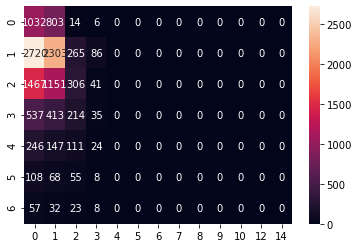

In [102]:
import seaborn as sns
sns.heatmap(
    data=pd.DataFrame(
        w,
        index=[0,1,2,3,4,5,6],
        columns=[f"{i}" for i,j in zip(b2[:-1], b2[1:])],
    ),
    annot=True,
    fmt=".0f",
)

In [103]:
hh_means = HH.groupby('HOMETAZ')[['INCOME', 'N_VEHICLES', 'HHSIZE',
       'N_TRIPS', 'N_TRIPS_HBW', 'N_TRIPS_HBO', 'N_TRIPS_NHB',
       'N_WORKERS']].mean().add_prefix('MEAN_')

In [104]:
hh_sums = HH.groupby('HOMETAZ')[['N_VEHICLES', 'HHSIZE',
       'N_TRIPS', 'N_TRIPS_HBW', 'N_TRIPS_HBO', 'N_TRIPS_NHB',
       'N_WORKERS']].sum()

In [105]:
hh_sums.rename(columns={
    'HHSIZE':"TOTAL_POP", 
    'N_WORKERS':"TOTAL_WORKERS", 
    'N_VEHICLES':"TOTAL_VEHICLES", 
    'N_TRIPS':"TOTAL_TRIPS", 
    'N_TRIPS_HBW':'TOTAL_TRIPS_HBW', 
    'N_TRIPS_HBO':"TOTAL_TRIPS_HBO", 
    'N_TRIPS_NHB':"TOTAL_TRIPS_NHB",
}, inplace=True)

In [106]:
taz_agg = pd.concat([hh_means, hh_sums], axis=1)

In [107]:
taz_agg['N_HOUSEHOLDS'] = HH.groupby('HOMETAZ').size()

In [108]:
taz_agg.index.name = "TAZ"

In [109]:
# Drop income and n_veh from persons, they are hh attributes for our demos

PER.drop(['N_VEHICLES','INCOME'], axis=1, inplace=True)

## Save

In [110]:
HH.to_csv(larch.exampville._files(seed).hh, index=False)
PER.to_csv(larch.exampville._files(seed).person, index=False)
f_tour.to_csv(larch.exampville._files(seed).tour)
taz_agg.to_csv(larch.exampville._files(seed).demographics)


In [111]:
larch.exampville._files(seed).demographics

'../../data_warehouse/exampville_demographics.csv.gz'

In [112]:
os.getcwd()

'/Users/jeffnewman/Git/larch/larch/doc/example'